In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import julian
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [3]:
#Bounding Box for Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

# Open up swaths:

In [4]:
# Stats on most destructive Philippines TCs
name_des = ['Haiyan (Yolanda)','Bopha (Pablo)','Rammasun (Glenda)','Parma (Pepeng)','Nesat (Pedring)','Koppu (Lando)','Fengshen (Frank)','Megi (Juan)','Ketsana (Ondoy)']
# Day before date of Phi landfall
dt_des = [datetime.date(2013,11,6),datetime.date(2012,12,2),datetime.date(2014,7,14),datetime.date(2009,10,2),datetime.date(2011,9,25),datetime.date(2015,10,16),datetime.date(2008,6,19),datetime.date(2010,10,17),datetime.date(2009,9,25)]
cost_des = [2.2e9,1.06e9,885e6,581e6,356e6,313e6,304e6,278e6,233e6]


# Start here picking out swaths of destructive storms.

In [5]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset('EXPOSED_VALUE/LitPopExposure_World.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.data
#ds_exp = xr.open_dataset('EXPOSED_VALUE/asia_exposed_value_reduced.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#exposed_value = ds_exp.exposed_value


In [6]:
# Regrid wind swath
swath_des = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths_des.nc').swath
regridder = xe.Regridder(swath_des, ds_exp, 'bilinear',reuse_weights=True)
swath_out_des = regridder(swath_des)


Reuse existing file: bilinear_146x111_1551x1124.nc


In [7]:
# Load Philippines province masks

d_mask = xr.open_dataset('/home/jbaldwin/WorldBank/Region_Masks/philippines_province_masks.nc')
pickle_in = open("/home/jbaldwin/WorldBank/Region_Masks/state_ids.p","rb")
state_ids = pickle.load(pickle_in)

In [8]:
# Load Vhalf values from household survey data

pickle_in = open("/home/jbaldwin/WorldBank/HOUSEHOLD_SURVEY_DATA/Vhalf_est.p","rb")
Vhalf_est = pickle.load(pickle_in)

In [52]:
# Calculate number of storms for different provinces
ts_per_year_map = xr.Dataset.copy(d_mask)
for key in regions:
    ts_per_year_map.states.values[ts_per_year_map.states==state_ids[key]] = ts_per_year[key]

ts_per_year_map.to_netcdf('ts_per_year.nc')

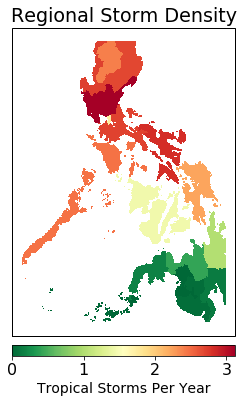

In [80]:
# Make plot of tropical storms per year
plt.figure(figsize=(4, 8))
plt.rcParams.update({'font.size': 16})
plt.subplot(111,projection=ccrs.PlateCarree())
p = ts_per_year_map.states.plot(transform=ccrs.PlateCarree(),cmap = plt.cm.RdYlGn_r, add_colorbar = False)
plt.title('Regional Storm Density')
cb = plt.colorbar(p, orientation="horizontal",pad=0.02)
cb.set_label(label='Tropical Storms Per Year',fontsize=14)
plt.savefig('FIGURES/ts_per_year.png',dpi=400)
#plt.tight_layout()

In [48]:
# Load tropical storms per year

pickle_in = open("/home/jbaldwin/WorldBank/ts_per_year.p","rb")
ts_per_year = pickle.load(pickle_in)

In [9]:
# Create list of state names

regions = state_ids.keys()


In [10]:
# Vulnerability for different provinces

Vhalf_map = xr.open_dataset('Vhalf_map.nc')
    

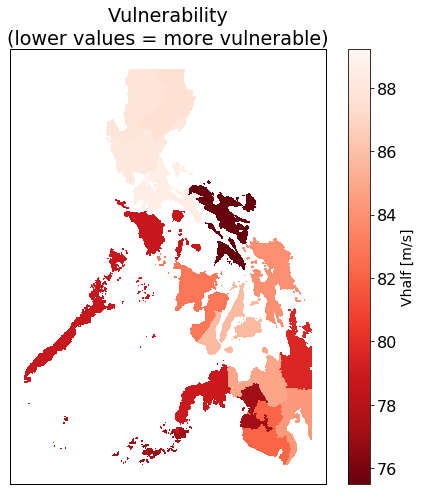

In [64]:
# Make plot of Vhalf across space (higher = less vulnerable)
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 16})
plt.subplot(111,projection=ccrs.PlateCarree())
p = Vhalf_map.states.plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Reds_r, add_colorbar = False)
plt.title('Vulnerability\n(lower values = more vulnerable)')
cb = plt.colorbar(p, orientation="vertical")
cb.set_label(label='Vhalf [m/s]',fontsize=14)
plt.savefig('FIGURES/vulnerability_map.png',dpi=400)


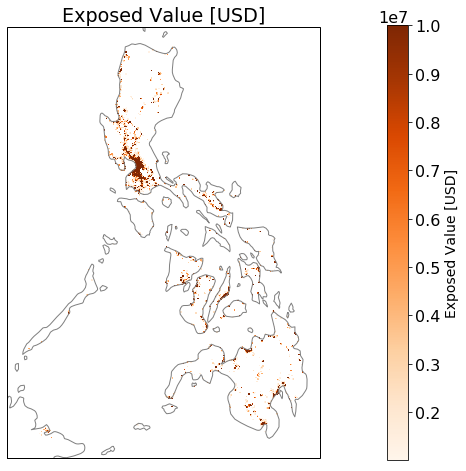

In [12]:
# Make plot of Exposed Value
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(111,projection=ccrs.PlateCarree())
p = exposed_value.plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Oranges, add_colorbar = False, vmax = 1e7)
p.axes.coastlines('50m',color='0.5')
plt.title('Exposed Value [USD]')
cb = plt.colorbar(p, orientation="vertical", pad=0.15)
cb.set_label(label='Exposed Value [USD]',fontsize=14)
#ax.add_feature(cfeature.OCEAN, zorder=100)
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
plt.savefig('FIGURES/exposed_value_map.png',dpi=400)

In [13]:
# Load the asset losses data
asset_losses = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_assetlosses_regvulnerability_des.nc').asset_losses
est_cost = asset_losses.sum(dim='lon').sum(dim='lat')

In [45]:
np.max(asset_losses[...,0].sel(lat = slice(latmin,latmax)))

<xarray.DataArray 'asset_losses' ()>
array(10471.096876)
Coordinates:
    nS       int64 0

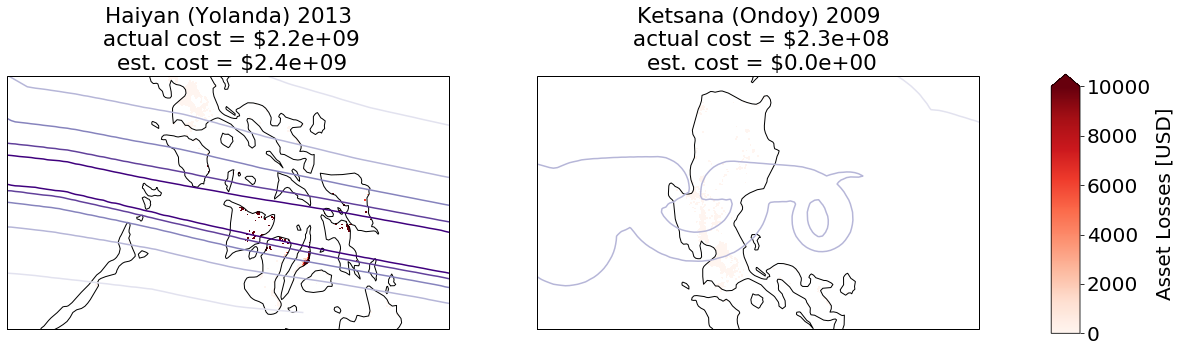

In [47]:
fig = plt.figure(figsize=(20, 9))
p = {}
plt.rcParams.update({'font.size': 18})
# lonmin = 117.17427453
# latmin = 5.58100332277
# lonmax = 126.537423944
# latmax = 18.5052273625

vmax = 10000

plt.subplot(1,2,1,projection=ccrs.PlateCarree())
n = 0
latmin = 9
latmax = 15
p[n] = asset_losses[...,n].sel(lat = slice(latmin,latmax)).plot(vmax = vmax,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds,extend = 'max', add_colorbar=False)
data = swath_des[n].sel(lat = slice(latmin,latmax))
data.plot.contour(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,60,10),add_colorbar=False,linewidth=0.5)
p[n].axes.coastlines('50m')
plt.title(name_des[n]+' '+str(dt_des[n].year)+'\n actual cost = $'+"{:.1e}".format(int(cost_des[n]),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])))

plt.subplot(1,2,2,projection=ccrs.PlateCarree())
n = 8
latmin = 13
latmax = 19
p[n] = asset_losses[...,n].sel(lat = slice(latmin,latmax)).plot(vmax = vmax,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds, extend = 'max', add_colorbar = False)
data = swath_des[n].sel(lat = slice(latmin,latmax))
data.plot.contour(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,60,10),add_colorbar=False,linewidth=0.5)
p[n].axes.coastlines('50m')
plt.title(name_des[n]+' '+str(dt_des[n].year)+'\n actual cost = $'+"{:.1e}".format(int(cost_des[n]),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
cb = fig.colorbar(p[8], cax=cbar_ax, extend = 'max')
cb.set_label(label='Asset Losses [USD]',size=20)
cb.ax.tick_params(labelsize=20) 
plt.savefig('FIGURES/historical_assetlosses.png',dpi=400)

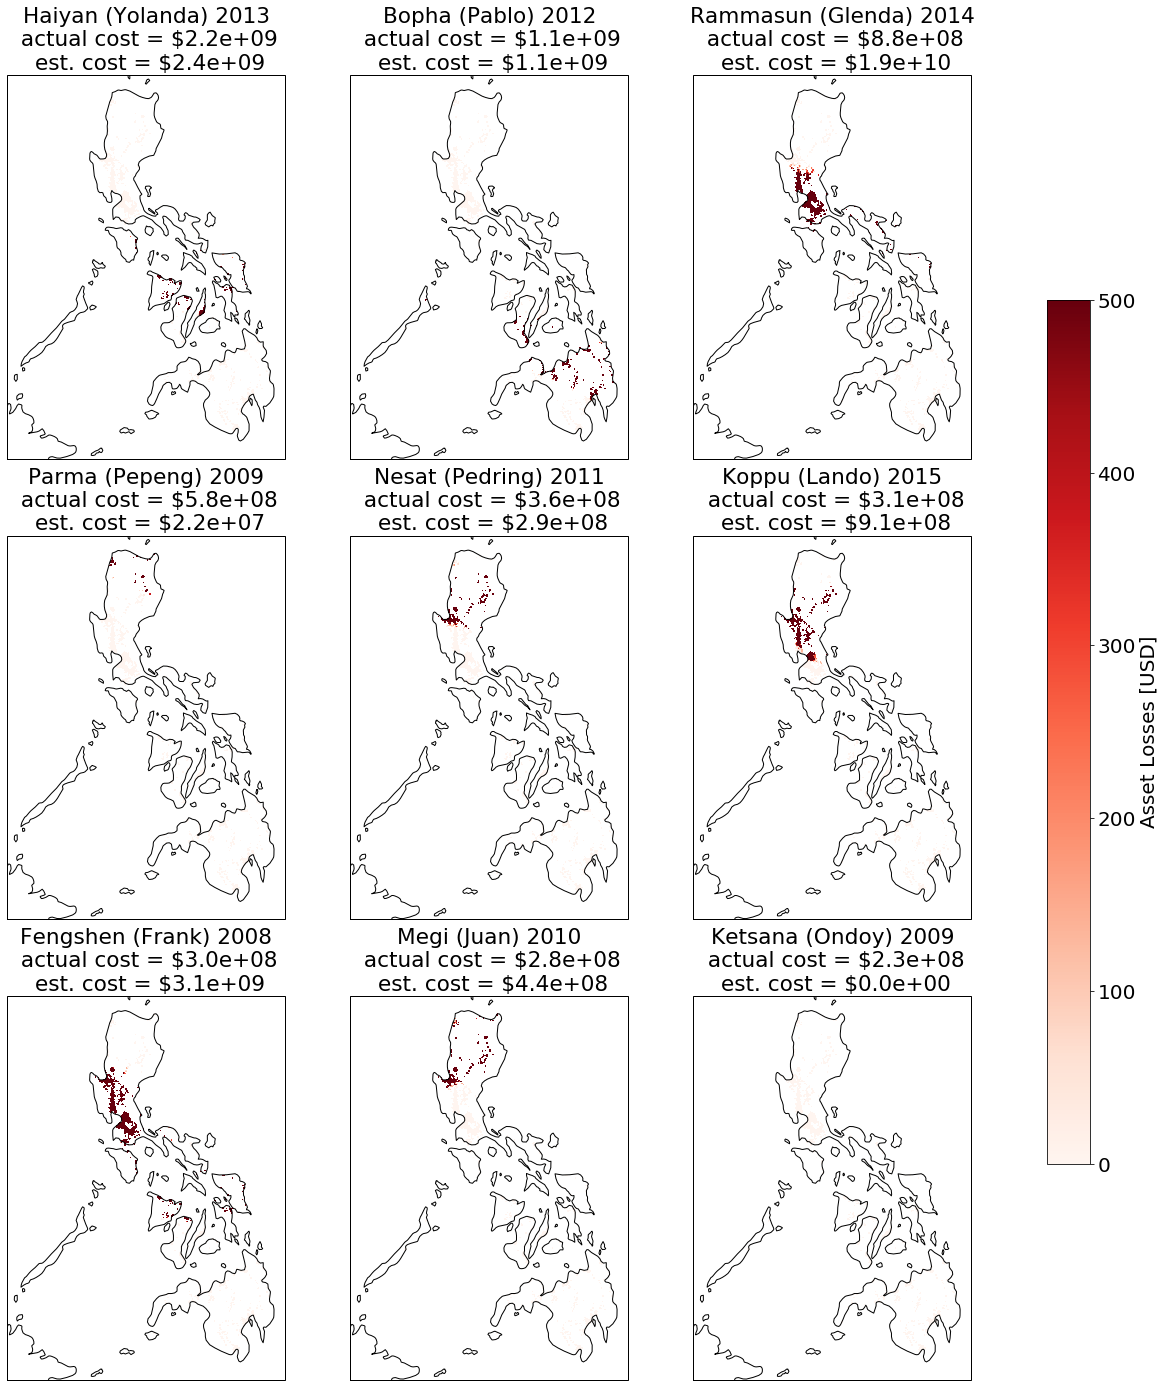

In [32]:
fig = plt.figure(figsize=(20, 24))
p = {}
plt.rcParams.update({'font.size': 18})
for n in np.arange(len(name_des)):
    plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p[n] = asset_losses[...,n].plot(vmax = 500,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds,add_colorbar=False)
    p[n].axes.coastlines('50m')
    plt.title(name_des[n]+' '+str(dt_des[n].year)+'\n actual cost = $'+"{:.1e}".format(int(cost_des[n]),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
cb = fig.colorbar(p[0], cax=cbar_ax)
cb.set_label(label='Asset Losses [USD]',size=20)
cb.ax.tick_params(labelsize=20) 
plt.savefig('FIGURES/historical_assetlosses.png',dpi=400)

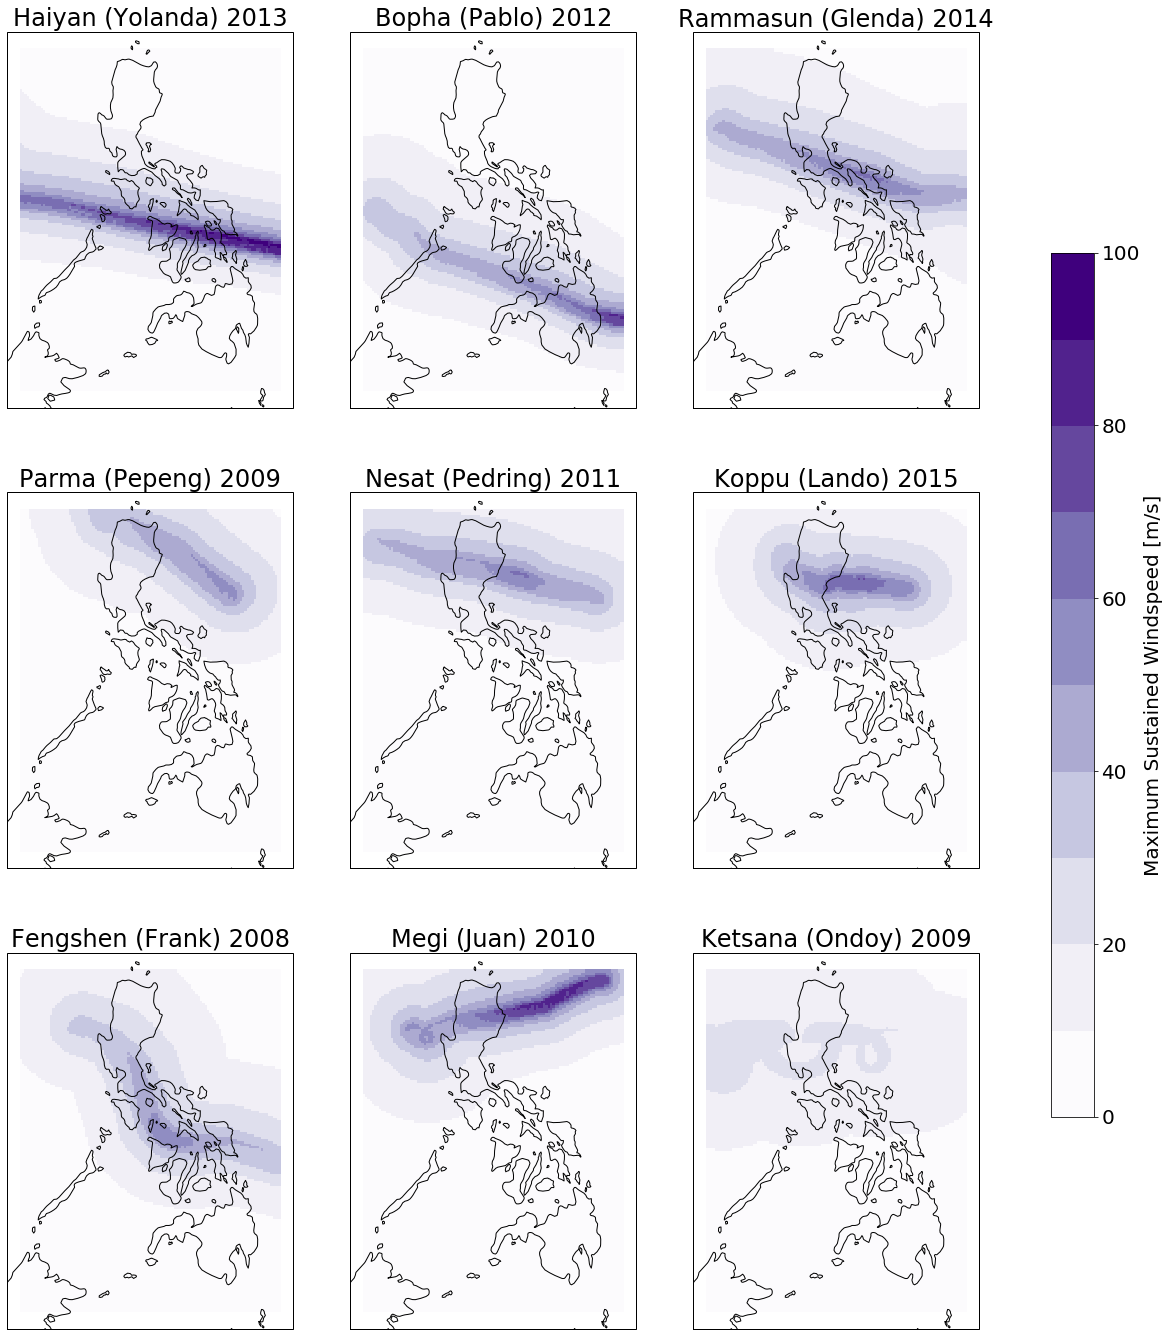

In [66]:
fig = plt.figure(figsize=(20, 24))
plt.rcParams.update({'font.size': 20})
for n in np.arange(len(name_des)):
    ax = plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = swath_des[n].plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,110,10),add_colorbar=False)
    plt.title(name_des[n]+' '+str(dt_des[n].year))
    ax.coastlines('50m')
    #cb = plt.colorbar(p, orientation="vertical", pad=0.15)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
cb = fig.colorbar(p, cax=cbar_ax)
cb.set_label(label='Maximum Sustained Windspeed [m/s]',size=20)
cb.ax.tick_params(labelsize=20) 
    
plt.savefig('FIGURES/historical_swaths.png',dpi=400)

# Calculate Exceedance Curves for Asset Losses

In [17]:
regions = ['Eastern Visayas','NCR','Central Luzon']
regions_nospace = {'Eastern Visayas':'EasternVisayas','NCR':'NCR','Central Luzon':'CentralLuzon'}

In [32]:
# Load data synthetic
ds_asset_losses = {}
asset_losses = {}
vector_assets = {}
period_years = {}
for reg in regions:
    ds_asset_losses[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_REGION/wpc0-2_assetlosses_'+regions_nospace[reg]+'.nc')
    asset_losses[reg] = ds_asset_losses[reg].asset_losses
    vector_assets[reg] = np.concatenate(asset_losses[reg])
    period_years[reg] = ds_asset_losses[reg].attrs['period_years']


In [33]:
# Load data historical
ds_asset_losses_hist = {}
asset_losses_hist = {}
period_years_hist = {}
for reg in regions:
    ds_asset_losses_hist[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_REGION/assetlosses_'+regions_nospace[reg]+'.nc')
    asset_losses_hist[reg] = ds_asset_losses_hist[reg].asset_losses
    period_years_hist[reg] = ds_asset_losses_hist[reg].attrs['period_years']

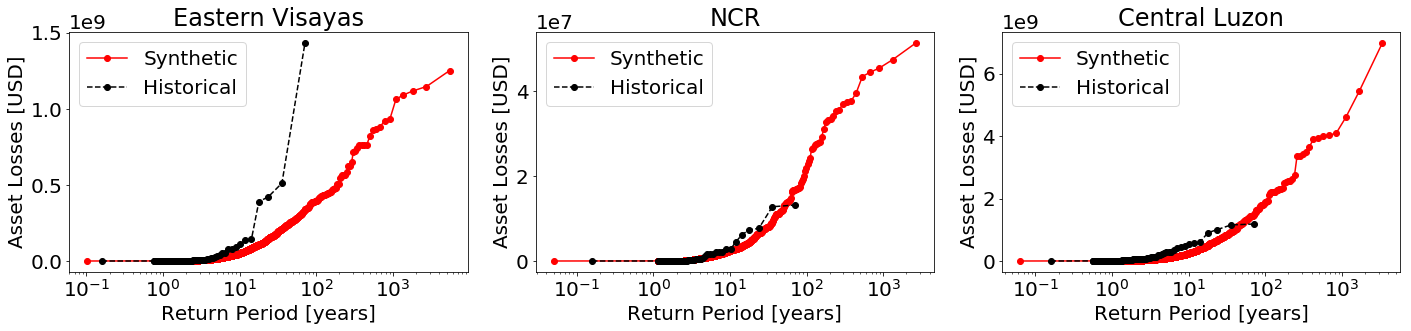

In [58]:
fig = plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 20})

for i in np.arange(3):
    reg = regions[i]
    ax = plt.subplot(1,3,i+1)
    obsw = vector_assets[reg]
    obsy = period_years[reg]
    pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],'r-',marker='o',label='Synthetic')
    
    obsw = asset_losses_hist[reg]
    obsy = period_years_hist[reg]
    pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],'k--',marker='o',label='Historical')
    
    plt.title(reg)
    plt.xlabel('Return Period [years]')
    plt.ylabel('Asset Losses [USD]')
    plt.legend()

plt.tight_layout()

plt.savefig('FIGURES/asset_losses_exceedance.png',dpi=400)

# Calculate number of storms reaching tropical storm strength in each region over period.

In [40]:
# Load data synthetic
ds_max_wind = {}
max_wind = {}
vector_wind = {}
period_years = {}
for reg in regions:
    ds_max_wind[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_REGION/wpc0-2_maxwind_'+regions_nospace[reg]+'.nc')
    max_wind[reg] = ds_max_wind[reg].max_wind
    vector_wind[reg] = np.concatenate(max_wind[reg])
    period_years[reg] = ds_max_wind[reg].attrs['period_years']

In [41]:
# Load data historical
ds_max_wind_hist = {}
max_wind_hist = {}
period_years_hist = {}
for reg in regions:
    ds_max_wind_hist[reg] = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_REGION/maxwind_'+regions_nospace[reg]+'.nc')
    max_wind_hist[reg] = ds_max_wind_hist[reg].max_wind
    period_years_hist[reg] = ds_max_wind_hist[reg].attrs['period_years']

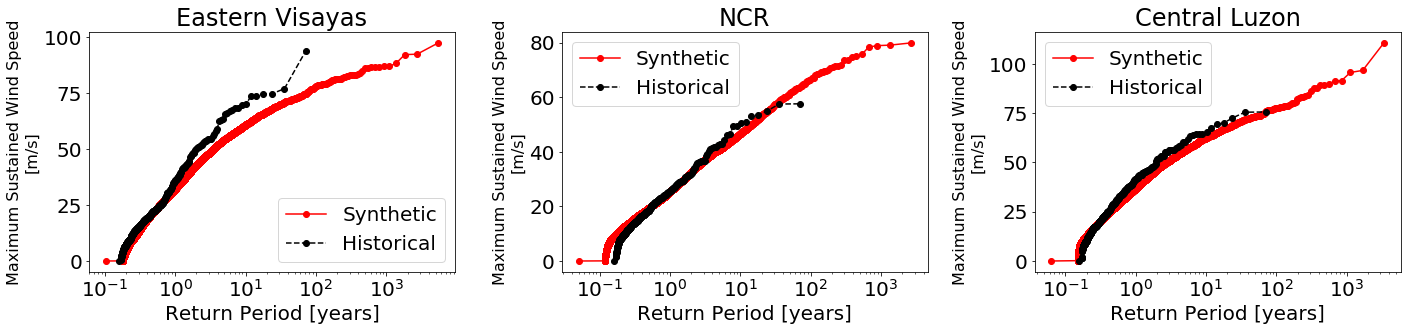

In [57]:
fig = plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 20})

for i in np.arange(3):
    reg = regions[i]
    ax = plt.subplot(1,3,i+1)
    obsw = vector_wind[reg]
    obsy = period_years[reg]
    pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],'r-',marker='o',label='Synthetic')
    
    obsw = max_wind_hist[reg]
    obsy = period_years_hist[reg]
    pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
    cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
    returnP_o = 1./cdfevents # calculate return period (1/f)
    dot, = ax.semilogx(returnP_o[:],bins[:-1],'k--',marker='o',label='Historical')
    
    plt.title(reg)
    plt.xlabel('Return Period [years]')
    plt.ylabel('Maximum Sustained Wind Speed\n[m/s]',fontsize = 16)
    plt.legend()
    
plt.tight_layout()
plt.savefig('FIGURES/max_wind_exceedance.png',dpi=400)

Text(0.5, 1.0, 'Eastern Visayas')

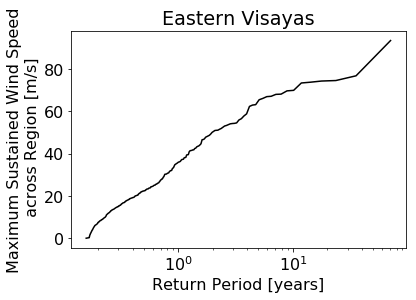

In [34]:
ax1 = plt.subplot(111)
obsw = max_wind['Eastern Visayas']
pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
returnP_o = 1./cdfevents # calculate return period (1/f)
dot, = ax1.semilogx(returnP_o[:],bins[:-1],'k-',label='obs',zorder=20)
plt.xlabel('Return Period [years]')
plt.ylabel('Maximum Sustained Wind Speed\n across Region [m/s]')
plt.title('Eastern Visayas')

In [24]:
# For synthetic storms, period should be set so frequency per year equals these values.
pickle_in = open("/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_REGION/e_asset_losses_CentralLuzon.p","rb")
e_asset_losses = pickle.load(pickle_in)

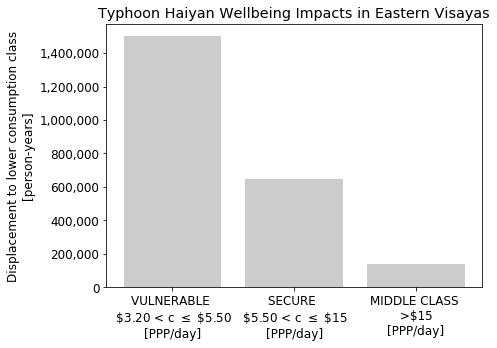

In [18]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(7, 5))

plt.subplot(111)
roof_labels = np.array(['VULNERABLE \n \$3.20 < c $\leq$ \$5.50 \n[PPP/day]','SECURE \n \$5.50 < c $\leq$ \$15 \n[PPP/day]','MIDDLE CLASS \n >\$15 \n[PPP/day]'])
plt.bar(np.arange(3),np.array([1500000,650000,140000]),color='0.8')
plt.xticks([0,1,2],roof_labels)
plt.yticks([0,200000,400000,600000,800000,1000000,1200000,1400000],['0','200,000','400,000','600,000','800,000','1,000,000','1,200,000','1,400,000'])
plt.ylabel('Displacement to lower consumption class\n[person-years]')
plt.title('Typhoon Haiyan Wellbeing Impacts in Eastern Visayas')
plt.tight_layout()
plt.savefig('FIGURES/haiyan_wellbeing_easternvisayas.png',dpi=400,pad_inches=0.5)